# benchmark structural regression

In [878]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import sys
from math import *
from scipy.stats import binned_statistic
import inspect

In [879]:
from utils_benchmark import * 
#test()

In [880]:
def plot_scatter_perc(df1,df2,xlabel,ylabel, palette = sns.dark_palette("#69d", reverse=True, as_cmap=True)): 
    sns.set_context("talk")
    f, ax = plt.subplots(figsize=(4, 3))
    df1 = df1.sort_values(by = "n_sequences")
    df2 = df2.sort_values(by = "n_sequences")
    
    x = np.array(df1.tc)
    y = np.array(df2.tc)
    hue = df2.n_sequences
    
    norm = plt.Normalize(hue.min(), hue.max())
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])

    ax = sns.scatterplot(x = x,
                    y = y,
                    hue = hue,
                    s = 80,
                    palette = palette )
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(x <= y)))) / len(list(x >= y))) * 100
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.xlim([0, 100])
    plt.ylim([0, 100])

    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = "regressive on homfam (n = "+str(len(x))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")


In [881]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"

## families infos

In [882]:
#### Load datasets informations (Homfam + extHomfam)
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})

## AF2 infos

In [883]:
# Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
af2_grouped = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/03_summary_af2_grouped.csv")

## running time

In [884]:
def extract_all_traces(dataset):
    # ---------- EXTRACT SEQUENCES ---------------
    #traces_extracted_sequences_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "seqs_extracted")
    # ---------- AF2 PREDICTIONS -------------------------
    # traces_af2_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "structures/colabfold")
    # ---------- ALIGNMENTS -------------------------
    traces_alignments_homfam = get_computation_times(join(evaluation_dir, dataset), dataset, "alignments", extralevel=True)
    # ---------- CONCATENATE AL OF THEM IN ONE ---------------
    traces = pd.concat([traces_alignments_homfam], ignore_index=True)
    return(traces)

traces = extract_all_traces("homfam")
traces.name.str.split(".", expand = True)[1].value_counts()

regressive     378
dynamic        365
progressive    189
Name: 1, dtype: int64

## msa evaluation 

In [885]:
# Define dataset 
dataset = "homfam"
eval_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/CSV/")


scores_df = get_evaluation_all(eval_dir)
# add AF2 
scores_df["benchmarking_dataset"] = dataset
scores_df = pd.merge(scores_df,af2_grouped,on = ["family", "benchmarking_dataset"])
scores_df["bucket_size"] = pd.to_numeric(scores_df.bucket_size)

# sep reference and full
scores_df["tag"] = scores_df.family.str.contains("_ref").map({True: 'ref', False: 'full'})
scores_df.family = scores_df.family.str.replace("_ref","")

scores_df.method.value_counts()

dynamic        354
regressive      65
progressive     65
Name: method, dtype: int64

In [886]:
scores_df_full = scores_df[scores_df.tag == "full"]
scores_df_ref = scores_df[scores_df.tag == "ref"]

## merge

In [887]:
def get_stats(scores_df, traces, summary_homfam_exthomfam):
    stats = pd.merge(scores_df, traces, on = ["name","benchmarking_dataset"])
    stats = pd.merge(stats, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
    stats_alignments = stats[stats.task == "alignments"]
    stats_alignments["approach"] = stats_alignments[["method", "bucket_size", "master_msa", "slave_msa", "dynamicX_val"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    stats_alignments["fam_approach"] = stats_alignments["family"]+"_"+stats_alignments["approach"]
    stats_alignments.tc = pd.to_numeric(stats_alignments.tc)
    return(stats_alignments)

In [888]:
stats_alignments_full = get_stats(scores_df_full, traces, summary_homfam_exthomfam)
stats_alignments_ref = get_stats(scores_df_ref, traces, summary_homfam_exthomfam)
# Only keep the ones with ref 
stats_alignments_full_sorted = stats_alignments_full.loc[stats_alignments_full.fam_approach.isin(stats_alignments_ref.fam_approach)]
stats_alignments_full_sorted = stats_alignments_full_sorted.sort_values(by=["family", "approach"]).reset_index()
stats_alignments_ref_sorted = stats_alignments_ref.sort_values(by=["family", "approach"]).reset_index()
# ----------   Get diff TC --------- 
stats_alignments_full_sorted["diff_tc"] = stats_alignments_full_sorted.tc - stats_alignments_ref_sorted.tc

In [889]:
stats_alignments_full = get_stats(scores_df_full, traces, summary_homfam_exthomfam)

stats_alignments_dynamic = stats_alignments_full[(stats_alignments_full.method == "dynamic")]
fams = stats_alignments_dynamic.family
stats_alignments_progressive = stats_alignments_full[(stats_alignments_full.method == "progressive") & (stats_alignments_full.family.isin(fams) )]
stats_alignments_regressive = stats_alignments_full[(stats_alignments_full.method == "regressive") & (stats_alignments_full.family.isin(fams) )]

# Plotting params 

In [890]:
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]
metrics = [["tc", "total column"]]
sns.set_context("talk")

In [891]:
prog = stats_alignments_progressive

reg_50 = stats_alignments_regressive[stats_alignments_regressive.bucket_size == 50]
reg_1000 = stats_alignments_regressive[stats_alignments_regressive.bucket_size == 1000]

dyn_1_famsa = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "1") & (stats_alignments_dynamic.master_msa == "famsa_msa")]
dyn_1_3d = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "1") & (stats_alignments_dynamic.master_msa == "tcoffee_msa")]

dyn_1000_famsa = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "1000") & (stats_alignments_dynamic.master_msa == "famsa_msa")]
dyn_1000_3d = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "1000") & (stats_alignments_dynamic.master_msa == "tcoffee_msa")]

dyn_100000000_famsa = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "100000000") & (stats_alignments_dynamic.master_msa == "famsa_msa")]
dyn_100000000_3d = stats_alignments_dynamic[(stats_alignments_dynamic.dynamicX_val == "100000000") & (stats_alignments_dynamic.master_msa == "tcoffee_msa")]

# Dynamic

## DyanmicX

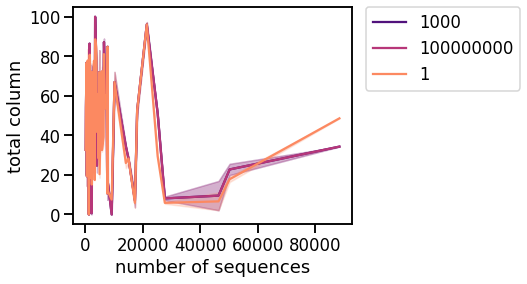

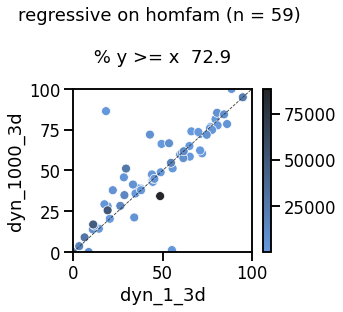

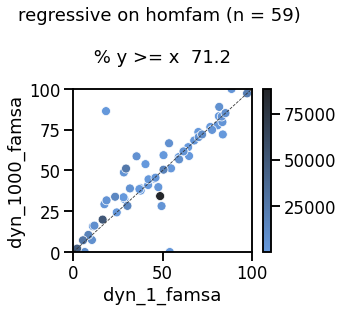

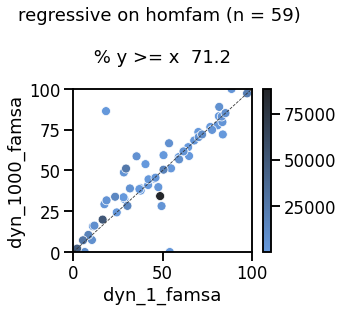

In [893]:
for metric in metrics:
    f, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(data=stats_alignments_dynamic, y=metric[0], x="n_sequences", hue="dynamicX_val",
                    palette = "magma")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=  metric[1], xlabel='number of sequences')

plot_scatter_perc(dyn_1_3d,dyn_1000_3d,'dyn_1_3d', 'dyn_1000_3d')
plot_scatter_perc(dyn_1_famsa,dyn_1000_famsa,'dyn_1_famsa', 'dyn_1000_famsa')
plot_scatter_perc(dyn_1_famsa,dyn_100000000_famsa,'dyn_1_famsa', 'dyn_1000_famsa')

## parent aligner 

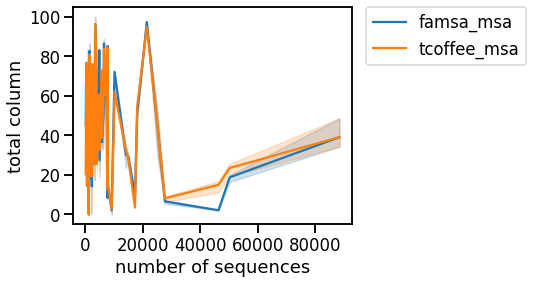

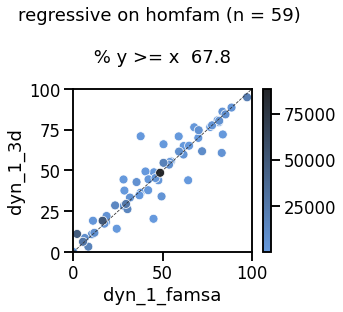

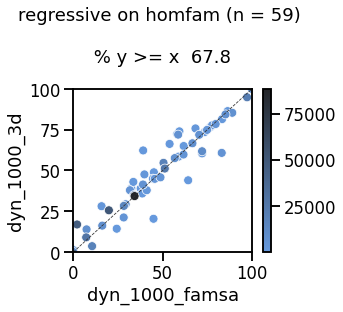

In [894]:
for metric in metrics:
    f, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(data=stats_alignments_dynamic, y=metric[0], x="n_sequences", hue="master_msa")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylabel=  metric[1], xlabel='number of sequences')
    
plot_scatter_perc(dyn_1_famsa,dyn_1_3d,'dyn_1_famsa', 'dyn_1_3d')
plot_scatter_perc(dyn_1000_famsa,dyn_1000_3d,'dyn_1000_famsa', 'dyn_1000_3d')

# Regressive

### Which is the bucket size effect? 

In [815]:
#plot_scatter_perc(reg_50,reg_1000,'reg50', 'reg1000')

# Compare dynamic vs regressive

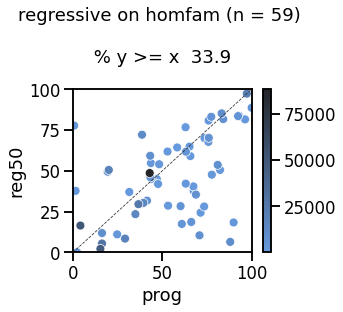

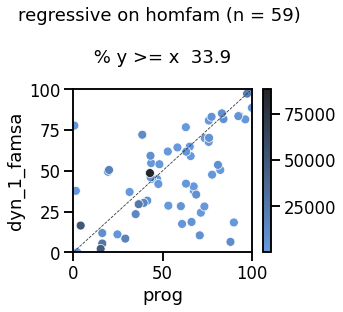

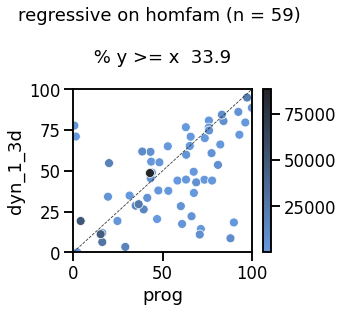

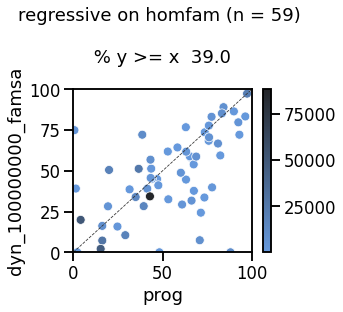

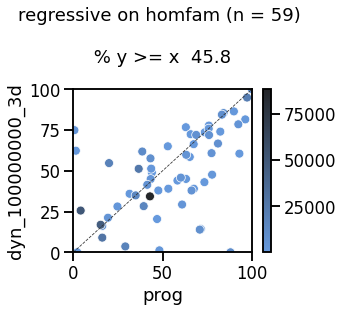

In [897]:
plot_scatter_perc(prog,reg_50,'prog', 'reg50')
#plot_scatter_perc(prog,reg_1000,'prog', 'reg1000')


plot_scatter_perc(prog,dyn_1_famsa,'prog', 'dyn_1_famsa')
plot_scatter_perc(prog,dyn_1_3d,'prog', 'dyn_1_3d')
plot_scatter_perc(prog,dyn_100000000_famsa,'prog', 'dyn_100000000_famsa')
plot_scatter_perc(prog,dyn_100000000_3d,'prog', 'dyn_100000000_3d')

# Cumulative average plot

88345
1068
9


[Text(0.5, 0, 'number of sequences')]

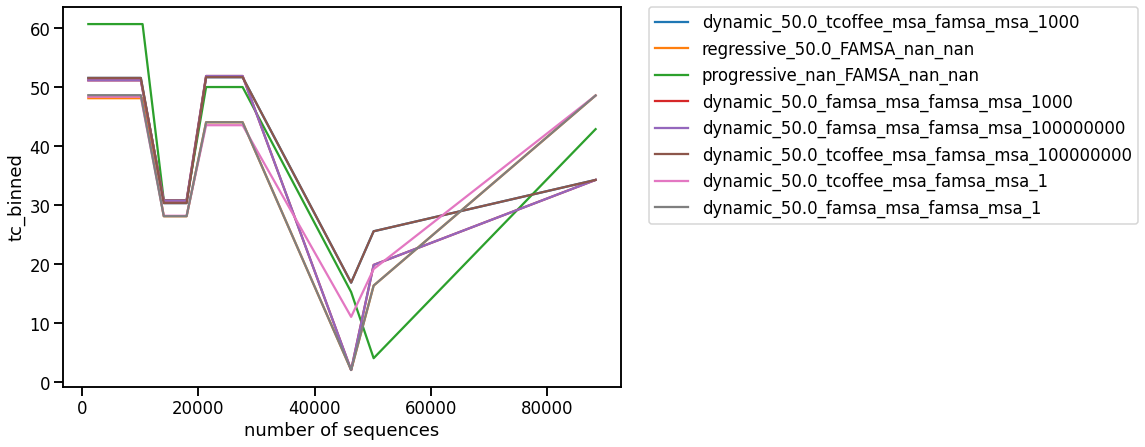

In [916]:
# try plotting with cumavg
sns.set_context("talk")
# Only keep 10k sequences or more 




bin_window = 10000
n_bins = ceil((df.n_sequences.max()-df.n_sequences.min())/bin_window)
print(df.n_sequences.max())
print(df.n_sequences.min())
print(n_bins)
df = stats_alignments_full[stats_alignments_full.n_sequences>1000]
df = df.sort_values(by=["n_sequences"], ascending=True)
df["seq_bin"] = pd.cut(df.n_sequences, n_bins)
bin_means = pd.DataFrame(df.groupby(["seq_bin", "approach"])["tc"].mean()).reset_index()
bin_means.columns = ['seq_bin', "approach", 'tc_binned']
bin_means.head(1)
df = pd.merge(df, bin_means, on = ["seq_bin","approach"])
df.head(2)


f, ax = plt.subplots(figsize=(10, 7))
x = df.n_sequences
y = (df.sort_values(by=["n_sequences"])["tc_binned"])
hue = df["approach"]

g_results = sns.lineplot(x = x, y = y, hue = hue, ci = "sd")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel='number of sequences')

# ---------------------

## Plot average and std 

In [610]:
def cumsum(x): 
    return(list(x).cumsum())
def cum_var(x):
    ind_na = x.notna()
    nn = ind_na.cumsum()
    x[x.isna()] = 0
    cumsum(x^2) / (nn-1) - (cumsum(x))^2/(nn-1)/nn

In [609]:
nonreg_co_co_full<- nonreg_co_co[nonreg_co_co$tag == 'full',]
nonreg_co_co_ref<- nonreg_co_co[nonreg_co_co$tag == 'ref',]
nonreg_co_co_full_sorted <- nonreg_co_co_full[order(-nonreg_co_co_full$nseqs),]
nonreg_co_co_ref_sorted <- nonreg_co_co_ref[order(-nonreg_co_co_ref$nseqs),]
nonreg_co_co_diff <-  nonreg_co_co_full_sorted$tc_score - nonreg_co_co_ref_sorted$tc_score 
nonreg_co_co_cumsum <- cumsum(nonreg_co_co_diff)
nonreg_co_co_cumavg<-nonreg_co_co_cumsum/seq_along(nonreg_co_co_cumsum)
nonreg_co_co_cumsd<-sqrt(cum_var(nonreg_co_co_cumavg))
nonreg_co_co_cumsd[is.na(nonreg_co_co_cumsd)] <- 0

SyntaxError: invalid syntax (4045124256.py, line 1)